# Library Imports

In [1]:
import os
import time
from typing import Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from gensim.models import Word2Vec
from google import genai
from google.api_core.exceptions import (
    DeadlineExceeded,
    ResourceExhausted,
    ServiceUnavailable,
)
from google.genai import types
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

/home/dino/projects/data-analytics-with-gen-ai-and-llms/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
RANDOM_STATE = 42
GEMINI_EMBEDDING_MODEL = "gemini-embedding-001"
MPNET_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"

# Data Loading

In [4]:
data = pd.read_csv("./data/IMDB Dataset.csv")

# Exploratory Analysis

In [5]:
data.shape

(50000, 2)

In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

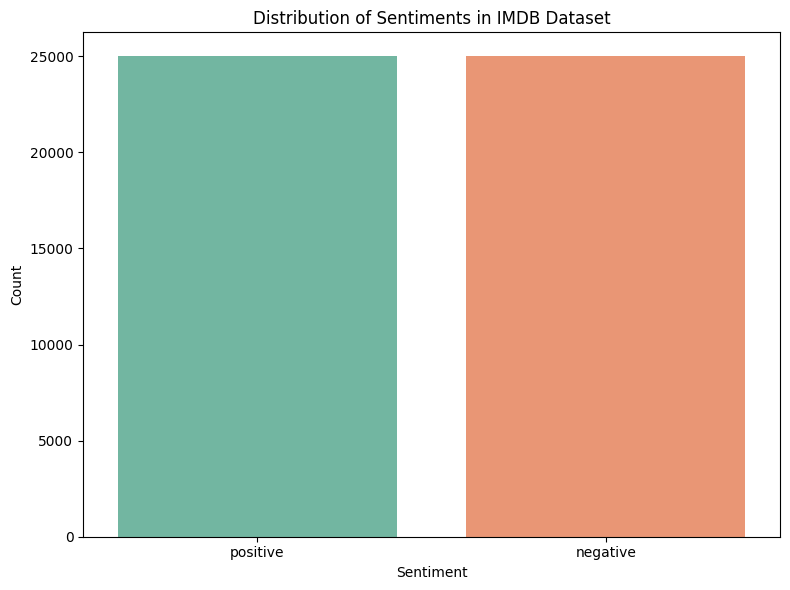

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(
    x="sentiment",
    data=data,
    palette="Set2",
    hue="sentiment",
)
plt.title("Distribution of Sentiments in IMDB Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(data["sentiment"].value_counts())

In [9]:
review_word_counts = data["review"].astype(str).str.split().str.len()
print(f"Average review length: {review_word_counts.mean():.2f} words")
print(f"Average string length: {data['review'].str.len().mean():.2f} characters")

Average review length: 231.16 words
Average string length: 1309.43 characters


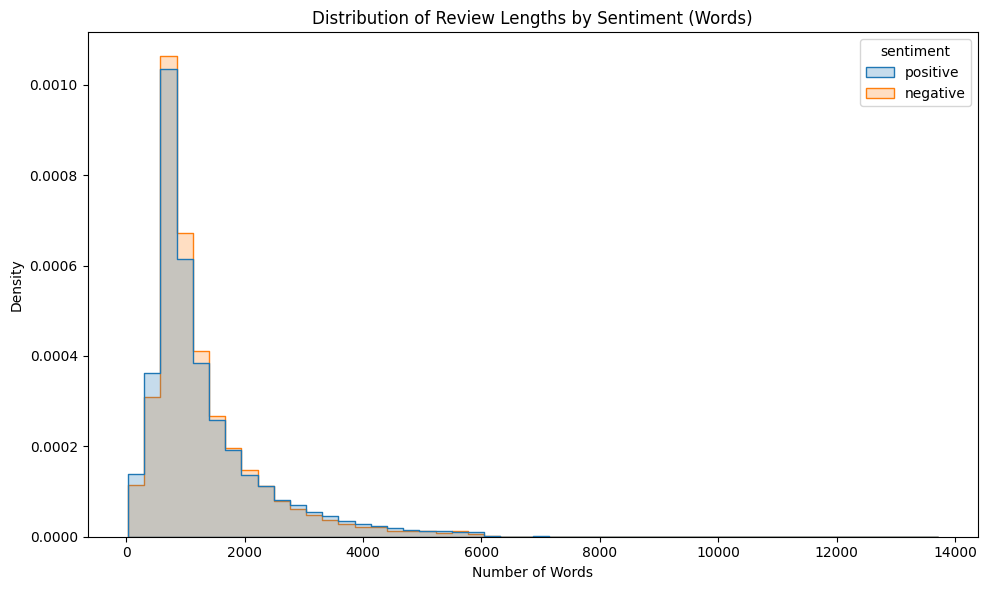

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=data,
    x=data["review"].str.len(),
    hue="sentiment",
    bins=50,
    element="step",
    stat="density",
    common_norm=False,
)
plt.title("Distribution of Review Lengths by Sentiment (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


# Data Preprocessing

In [11]:
def clean_text(text: str) -> str:
    """Cleans the input text by removing HTML tags and extra whitespace."""
    text = text.replace("<br />", " ")
    text = text.replace("\n", " ")
    text = " ".join(text.split())
    text = text.strip()
    return text

data["review"] = data["review"].apply(clean_text)

# Training XGBoost on TF-IDF Embeddings

In [12]:
def train_tfidf_xgb_baseline(
    df: pd.DataFrame,
    random_state: int,
) -> Tuple[XGBClassifier, TfidfVectorizer, LabelEncoder]:
    """
    Train a TF-IDF + XGBoost baseline classifier on raw text.

    Args:
        df: Input dataframe containing text and labels.

    Returns:
        model: Trained XGBoost model.
        vectorizer: Fitted TF-IDF vectorizer.
        encoder: Fitted label encoder.
    """
    x_raw = df["review"].astype(str).to_numpy()
    y_raw = df["sentiment"].to_numpy()

    encoder = LabelEncoder()
    y = encoder.fit_transform(y_raw)

    x_train_raw, x_test_raw, y_train, y_test = train_test_split(
        x_raw,
        y,
        test_size=0.2,
        random_state=random_state,
        stratify=y,
    )

    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.95,
        min_df=5,
        max_features=100_000,
        sublinear_tf=True,
    )

    x_train = vectorizer.fit_transform(x_train_raw)
    x_test = vectorizer.transform(x_test_raw)

    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        tree_method="hist",
        random_state=random_state,
    )

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    accuracy = float(accuracy_score(y_test, y_pred))

    print(f"TF-IDF + XGBoost accuracy: {accuracy:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

    return model, vectorizer, encoder

In [13]:
tfidf_xgb_model, tfidf_vectorizer, tfidf_encoder = train_tfidf_xgb_baseline(
    df=data,
    random_state=RANDOM_STATE
)

TF-IDF + XGBoost accuracy: 0.8774

Classification report:
              precision    recall  f1-score   support

    negative       0.89      0.86      0.88      5000
    positive       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



# Training XGBoost on Word2Vec Embeddings

In [14]:
def train_word2vec_model(
    texts: Sequence[str],
    vector_size: int = 300,
    window: int = 5,
    min_count: int = 5,
) -> Word2Vec:
    """
    Train a Word2Vec model on tokenized texts.

    Args:
        texts: Sequence of raw text documents.
        vector_size: Dimensionality of the word vectors.
        window: Maximum distance between the current and predicted word.
        min_count: Minimum frequency for a word to be included in the vocabulary.

    Returns:
        A trained Word2Vec model.
    """
    sentences = [t.split() for t in texts]
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4,
        sg=1,
    )
    return model


def build_review_embeddings(
    texts: Sequence[str],
    w2v_model: Word2Vec,
    vector_size: int,
) -> np.ndarray:
    """
    Create document embeddings by averaging Word2Vec word vectors.

    Args:
        texts: Sequence of raw text documents.
        w2v_model: Trained Word2Vec model.
        vector_size: Dimensionality of the word vectors.

    Returns:
        Array of shape (n_samples, vector_size) with document embeddings.
    """
    embeddings: list[np.ndarray] = []
    for text in texts:
        tokens = text.split()
        vectors = [
            w2v_model.wv[token]
            for token in tokens
            if token in w2v_model.wv
        ]
        if vectors:
            doc_vec = np.mean(vectors, axis=0)
        else:
            doc_vec = np.zeros(vector_size, dtype=np.float32)
        embeddings.append(doc_vec)
    return np.vstack(embeddings)


def train_word2vec_xgb(
    df: pd.DataFrame,
    random_state: int,
    vector_size: int = 300,
    window: int = 5,
    min_count: int = 5,
) -> Tuple[XGBClassifier, Word2Vec, LabelEncoder]:
    """
    Train an XGBoost classifier on averaged Word2Vec document embeddings.

    Args:
        df: Dataframe containing text and labels.
        random_state: Seed for reproducible train/test split.
        vector_size: Dimensionality of the word vectors.
        window: Maximum distance between the current and predicted word.
        min_count: Minimum frequency for a word to be included in the vocabulary.

    Returns:
        Tuple of (trained XGBClassifier, trained Word2Vec model, fitted LabelEncoder, test accuracy).
    """
    texts = df["review"].astype(str).to_list()
    y_raw = df["sentiment"].to_numpy()

    w2v_model = train_word2vec_model(
        texts=texts,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
    )

    x = build_review_embeddings(
        texts=texts,
        w2v_model=w2v_model,
        vector_size=vector_size,
    )

    encoder = LabelEncoder()
    y = encoder.fit_transform(y_raw)

    x_train, x_test, y_train, y_test = train_test_split(
        x,
        y,
        test_size=0.2,
        random_state=random_state,
        stratify=y,
    )

    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        tree_method="hist",
        random_state=random_state,
    )

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    accuracy = float(accuracy_score(y_test, y_pred))

    print(f"Word2Vec embeddings + XGBoost accuracy: {accuracy:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

    return model, w2v_model, encoder

In [15]:
w2v_xgb_model, w2v_model, w2v_encoder = train_word2vec_xgb(
    df=data,
    random_state=RANDOM_STATE,
)

Word2Vec embeddings + XGBoost accuracy: 0.8745

Classification report:
              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      5000
    positive       0.87      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



# Training XGBoost on MPNet Embeddings

In [16]:
def embed_with_transformer_encoder(
    texts: Sequence[str],
    model_name,
    batch_size: int = 64,
) -> np.ndarray:
    """
    Compute sentence embeddings using a transformer encoder model
    from the Sentence-Transformers framework.

    Args:
        texts: Iterable of input texts.
        model_name: Sentence-Transformers model identifier.
        batch_size: Batch size for encoding.

    Returns:
        2D NumPy array of shape (n_samples, embedding_dim).
    """
    model = SentenceTransformer(model_name)
    embeddings = model.encode(
        list(texts),
        batch_size=batch_size,
        convert_to_numpy=True,
        show_progress_bar=False,
        normalize_embeddings=True,
    )
    return embeddings


def train_mpnet_embeddings_xgb(
    df: pd.DataFrame,
    random_state: int,
    model_name,
    batch_size: int = 64,
) -> Tuple[XGBClassifier, LabelEncoder]:
    """Train an XGBoost classifier on transformer encoder sentence embeddings.

    Args:
        df: DataFrame containing text and labels.
        random_state: Seed for reproducible train/test split.
        model_name: Sentence-Transformers model identifier.
        batch_size: Batch size for embedding computation.

    Returns:
        model: Trained XGBoost model.
        encoder: Fitted label encoder.
    """
    texts = df["review"].astype(str).to_list()
    y_raw = df["sentiment"].to_numpy()

    x = embed_with_transformer_encoder(
        texts,
        model_name=model_name,
        batch_size=batch_size,
    )

    encoder = LabelEncoder()
    y = encoder.fit_transform(y_raw)

    x_train, x_test, y_train, y_test = train_test_split(
        x,
        y,
        test_size=0.2,
        random_state=random_state,
        stratify=y,
    )

    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        tree_method="hist",
        random_state=random_state,
    )

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    accuracy = float(accuracy_score(y_test, y_pred))

    print(f"Transformer encoder embeddings + XGBoost accuracy: {accuracy:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

    return model, encoder

In [17]:
mpnet_xgb_model, mpnet_encoder = train_mpnet_embeddings_xgb(
    df=data,
    random_state=RANDOM_STATE,
    model_name=MPNET_MODEL_NAME
)

Transformer encoder embeddings + XGBoost accuracy: 0.8963

Classification report:
              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      5000
    positive       0.89      0.90      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



# Train XGBoost on LLM Embeddings

In [18]:
client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))

In [19]:
def make_batches(
    client: genai.Client,
    texts: Sequence[str],
    token_cap: int = 2048,
) -> list[list[str]]:
    """
    Make batches of texts based on token count.
    If a single text exceeds the token cap, it is truncated to fit.

    Args:
        texts: Sequence of input texts.
        token_cap: Maximum tokens per batch.
    
    Returns:
        List of batches, each batch is a list of texts.
    """
    batches: list[list[str]] = []
    current_batch: list[str] = []
    current_tokens = 0
    cutoff_limit = int(token_cap * 0.99 * 4)

    for text in texts:
        tokens = client.models.count_tokens(
            model=GEMINI_EMBEDDING_MODEL, contents=text
        ).total_tokens
        
        if not tokens:
            raise ValueError("Token count returned zero.")

        if tokens > token_cap:
            text = text[:cutoff_limit]
            tokens = client.models.count_tokens(
                model=GEMINI_EMBEDDING_MODEL, contents=text
            ).total_tokens
            if not tokens:
                raise ValueError("Token count returned zero after truncation.")

        if current_batch and current_tokens + tokens > token_cap:
            batches.append(current_batch)
            current_batch = [text]
            current_tokens = tokens
        else:
            current_batch.append(text)
            current_tokens += tokens

    if current_batch:
        batches.append(current_batch)

    return batches


def request_embeddings(
    client: genai.Client,
    texts: Sequence[str],
    max_retries: int = 3,
    base_delay: float = 1.0,
    backoff_factor: float = 2.0,
) -> np.ndarray:
    """
    Request embeddings from the Gemini API with retry mechanism.

    Args:
        client: Gemini API client.
        texts: Sequence of input texts to embed.
        max_retries: Maximum number of retries for transient errors.
        base_delay: Base delay in seconds for retries.
        backoff_factor: Backoff factor for exponential backoff.
    
    Returns:
        Numpy array of embeddings.
    
    Raises:
        RuntimeError: If the request fails after maximum retries.
    """
    attempt = 0
    while True:
        try:
            result = client.models.embed_content(
                model=GEMINI_EMBEDDING_MODEL,
                contents=list(texts),
                config=types.EmbedContentConfig(task_type="CLASSIFICATION")
            ).embeddings
            if not result:
                raise ValueError("Received empty embeddings from the API.")
            embeddings = np.array([embedding.values for embedding in result])
            return embeddings

        except (ServiceUnavailable, DeadlineExceeded, ResourceExhausted) as exc:
            attempt += 1
            if attempt > max_retries:
                msg = (
                    f"Request failed after {max_retries} retries "
                    f"(batch_size={len(texts)})."
                )
                raise RuntimeError(msg) from exc
            
            retry_delay = base_delay * (backoff_factor ** (attempt - 1))
            time.sleep(retry_delay)

        except Exception as exc:
            raise RuntimeError("Embedding request failed") from exc


def create_embeddings(
    client: genai.Client,
    data: pd.DataFrame,
    token_cap: int = 2048,
):
    """
    Create embeddings for the 'review' column in the dataframe.
    
    Args:
        client: Gemini API client.
        data: Input dataframe with a 'review' column.
        token_cap: Maximum tokens per embedding batch.
    
    Returns:
        DataFrame with an added 'embedding' column containing embeddings.
    
    Raises:
        ValueError: If there are mismatches in expected embedding counts.
    """
    texts = data["review"].astype(str).tolist()
    batches = make_batches(client, texts, token_cap=token_cap)

    all_embeddings: list[np.ndarray] = []
    for batch in batches:
        batch_embeddings = request_embeddings(client, batch)
        if batch_embeddings.shape[0] != len(batch):
            msg = (
                "Embedding batch size mismatch: "
                f"expected {len(batch)}, got {batch_embeddings.shape[0]}"
            )
            raise ValueError(msg)
        all_embeddings.append(batch_embeddings)

    embeddings_array = np.vstack(all_embeddings)
    if embeddings_array.shape[0] != len(data):
        msg = (
            "Total embeddings count does not match dataframe length: "
            f"{embeddings_array.shape[0]} vs {len(data)}"
        )
        raise ValueError(msg)

    result = data.copy()
    result["embedding"] = list(embeddings_array)
    return result

In [20]:
embeddings_df = create_embeddings(client, data)
embeddings_df.head()

,review,sentiment,embedding
0,One of the other reviewers has mentioned that ...,positive,"[0.0061989604, -0.031387955, 0.027043328, -0.0..."
1,A wonderful little production. The filming tec...,positive,"[-0.024338042, 0.0013966992, 0.020048006, -0.0..."
2,I thought this was a wonderful way to spend ti...,positive,"[-0.006603666, -0.009139627, 0.0028142768, -0...."
3,Basically there's a family where a little boy ...,negative,"[0.012190616, -0.014728807, -0.010392375, -0.0..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[-0.0062160078, -0.019525683, 0.0048862267, -0..."


In [21]:
def train_llms_embeddings_xgb(
    df: pd.DataFrame,
    random_state: int,
) -> Tuple[XGBClassifier, LabelEncoder]:
    """
    Train an XGBoost classifier on precomputed embeddings.

    Args:
        df: DataFrame containing embeddings and labels.
        random_state: Random seed for reproducibility.

    Returns:
        model: Trained XGBoost model.
        encoder: Fitted label encoder.
    """
    x = np.array([np.array(emb) for emb in df["embedding"]])
    y_raw = df["sentiment"].to_numpy()

    encoder = LabelEncoder()
    y = encoder.fit_transform(y_raw)

    x_train, x_test, y_train, y_test = train_test_split(
        x,
        y,
        test_size=0.2,
        random_state=random_state,
        stratify=y,
    )

    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        tree_method="hist",
        random_state=random_state,
    )

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test accuracy: {accuracy:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

    return model, encoder


In [22]:
gemini_xgb_model, gemini_encoder = train_llms_embeddings_xgb(
    df=embeddings_df,
    random_state=RANDOM_STATE
)

Test accuracy: 0.9637

Classification report:
              precision    recall  f1-score   support

    negative       0.96      0.96      0.96      5000
    positive       0.96      0.96      0.96      5000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

